In [24]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import re

from tensorflow.keras.layers import Dense, LSTM, Input, Dropout, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

In [4]:
with open('train_data_true.txt', 'r', encoding='utf-8') as f:
    texts_true = f.readlines()
    texts_true[0] = texts_true[0].replace('\ufeff', '') #убираем первый невидимый символ

with open('train_data_false.txt', 'r', encoding='utf-8') as f:
    texts_false = f.readlines()
    texts_false[0] = texts_false[0].replace('\ufeff', '') #убираем первый невидимый символ

In [6]:
texts = texts_true + texts_false # соединяем их в единую коллекцию
count_true = len(texts_true) # количество положительных
count_false = len(texts_false) # количество отрицательных
total_lines = count_true + count_false # общее количество
print(count_true, count_false, total_lines)

84 88 172


In [10]:
maxWordsCount = 1000
# разбиваем на отдельные слова
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!–"—#$%&amp;()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r«»', lower=True, split=' ', char_level=False) 
tokenizer.fit_on_texts(texts) # тут всегда нужно передавать коллекцию строк. texst - уже коллекция


In [11]:
dist = list(tokenizer.word_counts.items())
print(dist[:10]) # 1е 10 слов и их частота встречаемости
print(texts[0][:100])

[('думайте', 1), ('позитивно', 4), ('и', 50), ('верьте', 3), ('в', 38), ('свою', 4), ('способность', 1), ('достигать', 1), ('отличных', 1), ('результатов', 1)]
Думайте позитивно и верьте в свою способность достигать отличных результатов. 



In [14]:
max_text_len = 10
data = tokenizer.texts_to_sequences(texts) # преобразуем текст в последовательность чисел
data_pad = pad_sequences(data, maxlen=max_text_len) # ограничивает длиной max_text_len , а недостаточные заполняем нулями начиная с начала
print(data_pad)

[[197  54   2 ... 199 200 201]
 [  0   4 202 ... 205   3  67]
 [206   3  67 ...   4 208 209]
 ...
 [  0  20  62 ...  53 850 851]
 [  0   0  43 ...  33   1 853]
 [  0   0   0 ...  70  65 194]]


In [16]:
#print( list(tokenizer.word_index.items()) )

In [18]:

X = data_pad 
Y = np.array([[1, 0]]*count_true + [[0, 1]]*count_false) # дублирует вектор count_true и count_false раз
print(X.shape, Y.shape)
# тут обучающая выборка полностью сформирована

(172, 10) (172, 2)


In [19]:
# перемешивание всех наблюдений 
indeces = np.random.choice(X.shape[0], size=X.shape[0], replace=False)
X = X[indeces]
Y = Y[indeces]


In [32]:
model = Sequential()
model.add(Embedding(maxWordsCount, 128, input_length = max_text_len))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(0.0001))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 10, 128)           128000    
                                                                 
 lstm_10 (LSTM)              (None, 10, 128)           131584    
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dense_5 (Dense)             (None, 2)                 130       
                                                                 
Total params: 309,122
Trainable params: 309,122
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
5/5 [==============================] - 3s 166ms/step - loss: 0.6935 - accuracy: 0.4453 - val_loss: 0.6924 - val_accuracy: 0.5143
Epoch 2/20
5/5 [==============================] - 0s 16ms/step - loss: 0.6910 - accuracy: 0.5766 - val_loss: 0.6920 - val_accuracy: 0.4286
Epoch 3/20
5/5 [==============================] - 0s 16ms/step - loss: 0.6883 - accuracy: 0.5547 - val_loss: 0.6914 - val_accuracy: 0.4286
Epoch 4/20
5/5 [==============================] - 0s 16ms/step - loss: 0.6859 - accuracy: 0.5474 - val_loss: 0.6907 - val_accuracy: 0.4000
Epoch 5/20
5/5 [==============================] - 0s 16ms/step - loss: 0.6833 - accuracy: 0.5474 - val_loss: 0.6899 - val_accuracy: 0.4000
Epoch 6/20
5/5 [==============================] - 0s 16ms/step - loss: 0.6800 - accuracy: 0.5474 - val_loss: 0.6888 - val_accuracy: 0.4000
Epoch 7/20
5/5 [==============================] - 0s 16ms/step - loss: 0.6761 - accuracy: 0.5474 - val_loss: 0.6874 - val_accuracy: 0.4000
Epoch 8/20
5/5 [==========

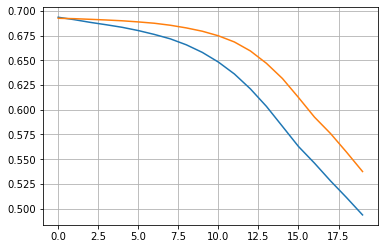

In [33]:
his = model.fit(X, Y, batch_size=32, epochs=20, validation_split=0.2)

plt.plot(his.history['loss']) # 2й history - словарь, loss - критерий качества
#, вычисленный для каждой эпохи
plt.plot(his.history['val_loss'])
plt.grid(True)
plt.show()

In [35]:
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

# преобразование в текст (чтобы посмотреть какую именно фразу мы анализируем) 
def sequence_to_text(list_of_indices):
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)

In [46]:
# блок, преобразующий текст в цифры
t = "Я люблю позитив".lower()
data = tokenizer.texts_to_sequences([t])
data_pad = pad_sequences(data, maxlen=max_text_len)
print("анализируемая фраза: ", sequence_to_text(data[0]) ) 

res = model.predict(data_pad)
print("Вывод сети:", res, "Т.е это:", np.argmax(res), sep='\n')

анализируемая фраза:  ['я', 'позитив']
Вывод сети:
[[0.05152439 0.94847566]]
Т.е это:
1
